In [30]:
import tensorflow as tf
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc


In [31]:
df=pd.read_csv("final_data.csv",parse_dates=True)
print(df.head())

   Free  hour  minu  weekday
0     0     0     0        0
1     0     0    15        0
2     0     0    30        0
3     0     0    45        0
4     0     1     0        0


In [32]:
CSV_COLUMN_NAMES = ['Free','hour','minu','weekday']


In [33]:
def load_traindata(label_name='Free'):
    """Parses the csv file in TRAIN_URL ."""
    train_path="train_data1.csv" # For Training NN model

    train = pd.read_csv(filepath_or_buffer=train_path,
                        names=CSV_COLUMN_NAMES,  # list of column names
                        header=0,  # ignore the first row of the CSV file.
                        skipinitialspace=True,
                        #skiprows=1
                       )

    train.hour = train.hour.astype(str)
    train.minu= train.minu.astype(str)
    train.weekday= train.weekday.astype(str)
    

    train_features, train_label = train, train.pop(label_name)

    return (train_features, train_label)

In [34]:
# we Are obtaining training features and labels from train_data1.csv

(train_feature, train_label) = load_traindata()


In [35]:
print(train_feature.head())
print(train_label.head())

  hour minu weekday
0    0    0       0
1    0   15       0
2    0   30       0
3    0   45       0
4    1    0       0
0    0
1    0
2    0
3    0
4    0
Name: Free, dtype: int64


In [36]:
#creating normal features and crossed features for the nn model

weekday = tf.feature_column.categorical_column_with_vocabulary_list(
    'weekday', ['0', '1', '2', '3', '4','5','6'])
hour = tf.feature_column.categorical_column_with_vocabulary_list(
    'hour', [ '0', '1', '2', '3', '4','5','6','7','8','10','12','13','14','15','16','17','18','19','20','21','22','23'])
minu = tf.feature_column.categorical_column_with_vocabulary_list(
    'minu', [ '0', '15', '30', '45'])

base_columns = [
    tf.feature_column.indicator_column(weekday),
    tf.feature_column.indicator_column(hour),
    tf.feature_column.indicator_column(minu)
]


weekday_x_hour_x_minu = tf.feature_column.crossed_column(
    ['weekday', 'hour','minu'], hash_bucket_size=1000)

weekday_x_hour = tf.feature_column.crossed_column(
    ['weekday', 'hour'], hash_bucket_size=1000)

hour_x_minu = tf.feature_column.crossed_column(
    ['hour','minu'], hash_bucket_size=1000)

crossed_columns = [
     tf.feature_column.indicator_column(weekday_x_hour_x_minu),
     tf.feature_column.indicator_column(weekday_x_hour) , 
     tf.feature_column.indicator_column(hour_x_minu)
]

In [37]:
#running Dnn classifer model with the features designed above and with 2 hidden layers (with 4 nodes and 2 nodes) and input layer with 6 nodes
classifier = tf.estimator.DNNClassifier(feature_columns=base_columns+crossed_columns,hidden_units=[6, 4,2],n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_keep_checkpoint_max': 5, '_evaluation_master': '', '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_master': '', '_task_type': 'worker', '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_is_chief': True, '_model_dir': 'C:\\Users\\Koushik\\AppData\\Local\\Temp\\tmp3qnwcyws', '_service': None, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002383FF1C780>}


In [38]:
#training the nnmodel

def train_input_fn(features, labels, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
        
        dataset = dataset.shuffle(buffer_size=1000).repeat(count=None).batch(batch_size)
        
        return dataset.make_one_shot_iterator().get_next()


classifier.train(
        input_fn=lambda:train_input_fn(train_feature, train_label, 50 ),
        steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Koushik\AppData\Local\Temp\tmp3qnwcyws\model.ckpt.
INFO:tensorflow:loss = 34.68165, step = 1
INFO:tensorflow:global_step/sec: 57.7198
INFO:tensorflow:loss = 12.922724, step = 101 (1.735 sec)
INFO:tensorflow:global_step/sec: 55.3442
INFO:tensorflow:loss = 12.39118, step = 201 (1.805 sec)
INFO:tensorflow:global_step/sec: 63.0906
INFO:tensorflow:loss = 8.415089, step = 301 (1.580 sec)
INFO:tensorflow:global_step/sec: 59.9505
INFO:tensorflow:loss = 7.9561324, step = 401 (1.669 sec)
INFO:tensorflow:global_step/sec: 56.4772
INFO:tensorflow:loss = 7.541585, step = 501 (1.775 sec)
INFO:tensorflow:global_step/sec: 60.317
INFO:tensorflow:loss = 15.2248955, step = 601 (1.656 sec)
INFO:tensorflow:global_step/se

In [39]:
def eval_input_fn(features, labels=None, batch_size=None):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert inputs to a tf.dataset object.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()



In [40]:
#predicting for all time intevals in a day with the trained model
df=pd.read_csv("topredict.csv",parse_dates=True)

predict_x= {  'hour':[ ],
        'minu':[ ] ,
        'weekday':[ ]
}

print(len(df))

predict_x['hour'] = df.hour.astype(str)
predict_x['minu']= df.minu.astype(str)
predict_x['weekday']= df.weekday.astype(str)
df['Free'] = [0 for x in range(df.shape[0])]
print(df.head())



672
   Free  hour  minu  weekday
0     0     0    15        3
1     0     0    30        3
2     0     0    45        3
3     0     1     0        3
4     0     1    15        3


In [41]:

predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(predict_x,
                                  labels=None,
                                  batch_size=50))
print(predictions)


i=0
for pred_dict in zip(predictions):
    if pred_dict[0]['classes'] == [b'1']:
        
        df.iloc[i,0]=1
        
    i=i+1



<generator object Estimator.predict at 0x0000023892D07F10>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Koushik\AppData\Local\Temp\tmp3qnwcyws\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [42]:
df.to_csv("predictedValue.csv",mode = 'w', index=False)

In [43]:
#similar to load_traindata but for this is done for testing data set
def load_test_data(label_name='Free'):
    
    test_path = "test_data.csv"
    
    test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0,  # ignore the first row of the CSV file.
                        skipinitialspace=True,
                        skiprows=1)


    test.hour = test.hour.astype(str)
    test.minu= test.minu.astype(str)
    test.weekday= test.weekday.astype(str)
    
    print(test.dtypes)
    test_features, test_label = test, test.pop(label_name)    
    return (test_features, test_label)
    

In [44]:
(test_feature, test_label) = load_test_data()

print(test_feature.head())

Free        int64
hour       object
minu       object
weekday    object
dtype: object
  hour minu weekday
0    0   30       3
1    0   45       3
2    1    0       3
3    1   15       3
4    1   30       3


In [45]:
#reading for test data set for testing purposes 

df=pd.read_csv("test_data1.csv",parse_dates=True)

test_feature= {  'hour':[ ],
        'minu':[ ] ,
        'weekday':[ ]
}

print(len(df))

test_label=[]
test_feature['hour'] = df.hour.astype(str)
test_feature['minu']= df.minu.astype(str)
test_feature['weekday']= df.weekday.astype(str)
test_label=list(df.Free.astype(int))
print(df.head())


436
   Free  hour  minu  weekday
0     0    10    15        3
1     0    10    30        3
2     0    10    45        3
3     0    11     0        3
4     0    11    15        3


In [46]:
print(len(test_label))

436


In [47]:

predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(test_feature,
                                  labels=None,
                                  batch_size=50))
print(predictions)


i=0
pred_label=[]
for pred_dict in zip(predictions):
    if pred_dict[0]['classes'] == [b'1']:
        
        pred_label.append(1)
        
    else:
        pred_label.append(0)
    i=i+1

print(len(pred_label))

<generator object Estimator.predict at 0x0000023892F79F10>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Koushik\AppData\Local\Temp\tmp3qnwcyws\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
436


In [48]:
#ploting a confusion matrix with the tested data 

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    print("Auc of classifer is ")
    print(roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [49]:
con_mat =tf.confusion_matrix(test_label,pred_label )
cm=[]
print('Confusion Matrix: \n\n')
with tf.Session():
    cm=tf.Tensor.eval(con_mat,feed_dict=None, session=None)
print(cm)

Confusion Matrix: 


[[174 116]
 [ 34 112]]


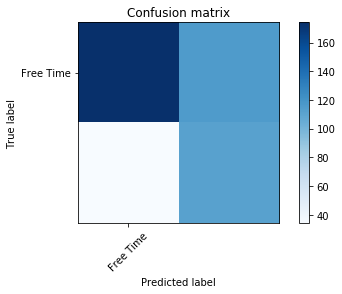

In [50]:
plt.figure()
diagnosis=["Free Time"]
plot_confusion_matrix(cm, diagnosis)

Normalized confusion matrix
[[0.6        0.4       ]
 [0.23287671 0.76712329]]


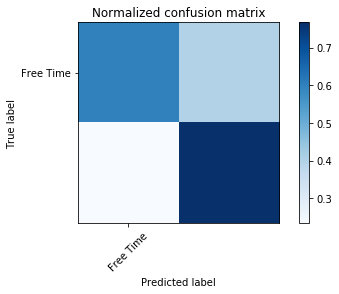

In [51]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, diagnosis, title='Normalized confusion matrix')

plt.show()

Auc of classifer is 
0.6835616438356165


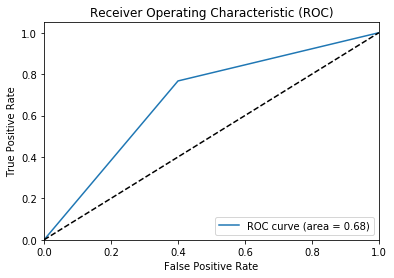

In [52]:

plot_roc(pred_label,test_label)